In [11]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Distribuciones candidatas
distribuciones = {
    'exponencial': stats.expon,
    'normal': stats.norm,
    'weibull': stats.weibull_min,
    'lognormal': stats.lognorm,
    'gamma': stats.gamma,
    'triangular': stats.triang
}

def chi_cuadrado_test(data, distrib, params, bins=30):
    freq_obs, bin_edges = np.histogram(data, bins=bins)
    cdf_vals = distrib.cdf(bin_edges, *params)
    freq_esp = len(data) * np.diff(cdf_vals)
    chi2 = ((freq_obs - freq_esp)**2 / freq_esp).sum()
    df = bins - len(params) - 1
    p_value = 1 - stats.chi2.cdf(chi2, df)
    return chi2, p_value

def ajustar_distribuciones(data):
    resultados = []
    x = np.linspace(min(data), max(data), 1000)

    for nombre, distrib in distribuciones.items():
        try:
            if nombre == 'weibull':
                params = distrib.fit(data, floc=0)  # Forzar Weibull de 2 parámetros
            else:
                params = distrib.fit(data)
            pdf_ajustada = distrib.pdf(x, *params)

            # Interpolación para RMSE
            hist, bins = np.histogram(data, bins=30, density=True)
            bin_centers = 0.5 * (bins[1:] + bins[:-1])
            pdf_interp = np.interp(bin_centers, x, pdf_ajustada)
            rmse = np.sqrt(mean_squared_error(hist, pdf_interp))

            # Pruebas estadísticas
            ks_stat, ks_p = stats.kstest(data, distrib.name, args=params)
            chi2_stat, chi2_p = chi_cuadrado_test(data, distrib, params)

            resultados.append({
                'nombre': nombre,
                'params': params,
                'rmse': rmse,
                'ks_pvalue': ks_p,
                'ks_stat': ks_stat,
                'chi2_stat': chi2_stat,
                'chi2_pvalue': chi2_p
            })

        except Exception as e:
            print(f"Error ajustando {nombre}: {e}")

    return sorted(resultados, key=lambda x: x['rmse'])

def graficar_resultados(data, mejores_resultados):
    x = np.linspace(min(data), max(data), 1000)
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, density=True, alpha=0.5, label='Datos')

    for res in mejores_resultados:
        distrib = distribuciones[res['nombre']]
        params = res['params']
        y = distrib.pdf(x, *params)
        plt.plot(x, y, label=f"{res['nombre']} (RMSE={res['rmse']:.3f})")

    plt.legend()
    plt.title("Ajuste de distribuciones")
    plt.xlabel("Valor")
    plt.ylabel("Densidad")
    plt.grid(True)
    plt.show()

def qq_pp_plots(data, nombre, distrib, params):
    sorted_data = np.sort(data)
    cdf_empirica = np.arange(1, len(data)+1) / len(data)
    cdf_teorica = distrib.cdf(sorted_data, *params)
    quantiles_modelo = distrib.ppf(cdf_empirica, *params)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # QQ plot
    axs[0].plot(quantiles_modelo, sorted_data, 'o')
    axs[0].plot([min(data), max(data)], [min(data), max(data)], 'r--')
    axs[0].set_title(f"QQ Plot - {nombre}")
    axs[0].set_xlabel("Cuantiles teóricos")
    axs[0].set_ylabel("Cuantiles empíricos")

    # PP plot
    axs[1].plot(cdf_teorica, cdf_empirica, 'o')
    axs[1].plot([0, 1], [0, 1], 'r--')
    axs[1].set_title(f"PP Plot - {nombre}")
    axs[1].set_xlabel("CDF teórica")
    axs[1].set_ylabel("CDF empírica")

    plt.tight_layout()
    plt.show()



In [33]:
datos = pd.read_excel("Proyecto Simulación.xlsx", sheet_name="Personas", usecols='A:I')
datos.drop(columns = ["Hora", "Tiempo llegadas(min)", "Hora subida", "Hora dif", "Tiempo subida (min)", "Tiempo subida (seg)"], inplace = True)
datos = datos.iloc[:1112]
datos.info()
personas_llegada = np.array(datos['Tiempo llegadas(seg)'].astype('float'))
personas_subida = np.array(datos[datos['Tiempo entre subida']<= 20]['Tiempo entre subida'].astype('float')) #Elimina los outliers (tiempos en los que no había bus)

datos = pd.read_excel("Proyecto Simulación.xlsx", sheet_name="Buses", usecols='A:I')
datos.drop(columns = ["Hora Lleg.", "Hora entre", "T. entre lleg. (min)", "Hora Salida", "Hora para Salida", "T. Salida (min)"], inplace = True)
datos.info()
buses_llegada = np.array(datos['T. entre lleg. (seg)'].astype('float'))
buses_salida = np.array(datos['T. Salida (seg)'].astype('float'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Persona               1112 non-null   int64  
 1   Tiempo llegadas(seg)  1112 non-null   float64
 2   Tiempo entre subida   1112 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 26.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Bus                   20 non-null     int64
 1   T. entre lleg. (seg)  20 non-null     int64
 2   T. Salida (seg)       20 non-null     int64
dtypes: int64(3)
memory usage: 612.0 bytes


In [30]:
x = np.linspace(min(personas_llegada), max(personas_llegada), 1000)

C:\Users\raalv\AppData\Local\Temp\ipykernel_4384\3044459105.py:21: RuntimeWarning: divide by zero encountered in divide
  chi2 = ((freq_obs - freq_esp)**2 / freq_esp).sum()
c:\Users\raalv\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_continuous_distns.py:2757: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))
c:\Users\raalv\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_continuous_distns.py:6911: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)



Resultados:
lognormal    - RMSE: 0.0039 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → LogNormal(0.5184, 1.1972)
weibull      - RMSE: 0.0157 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → Weibull(0.7871, 3.1255)
exponencial  - RMSE: 0.0191 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → Exponential(3.7136)
gamma        - RMSE: 0.0226 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → Gamma(0.5193, 8.3028)
normal       - RMSE: 0.0442 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → Normal(3.7136, 6.3164)
triangular   - RMSE: 0.0500 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → Triangular(-0.0485, 0.2400, 61.4320)


c:\Users\raalv\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_continuous_distns.py:2757: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


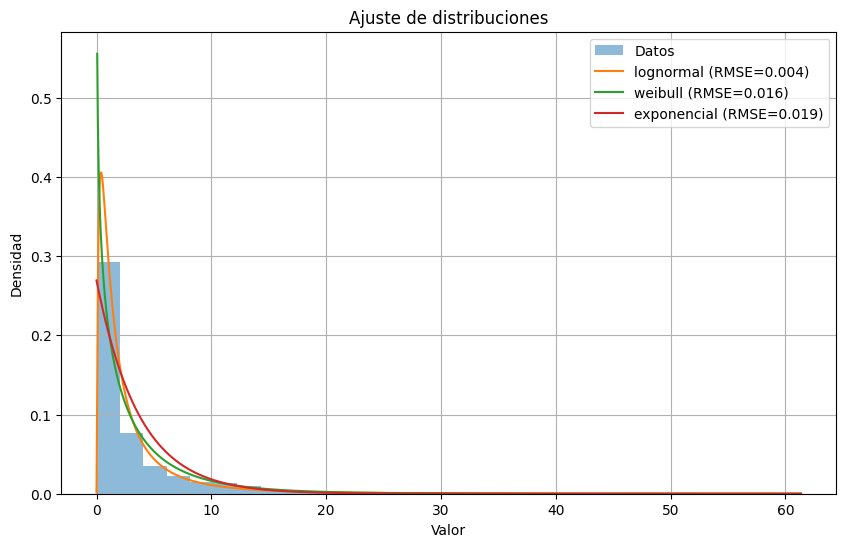

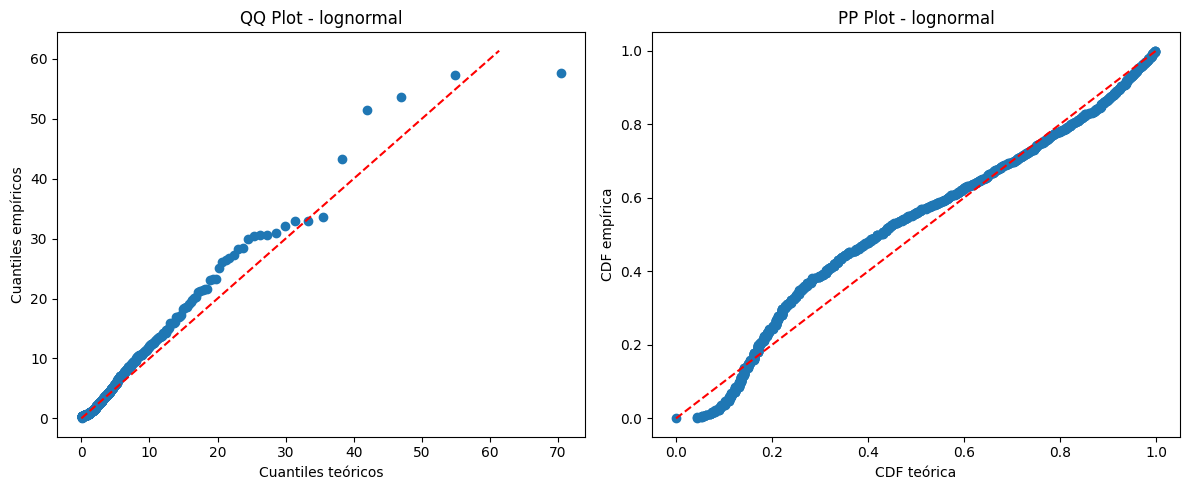

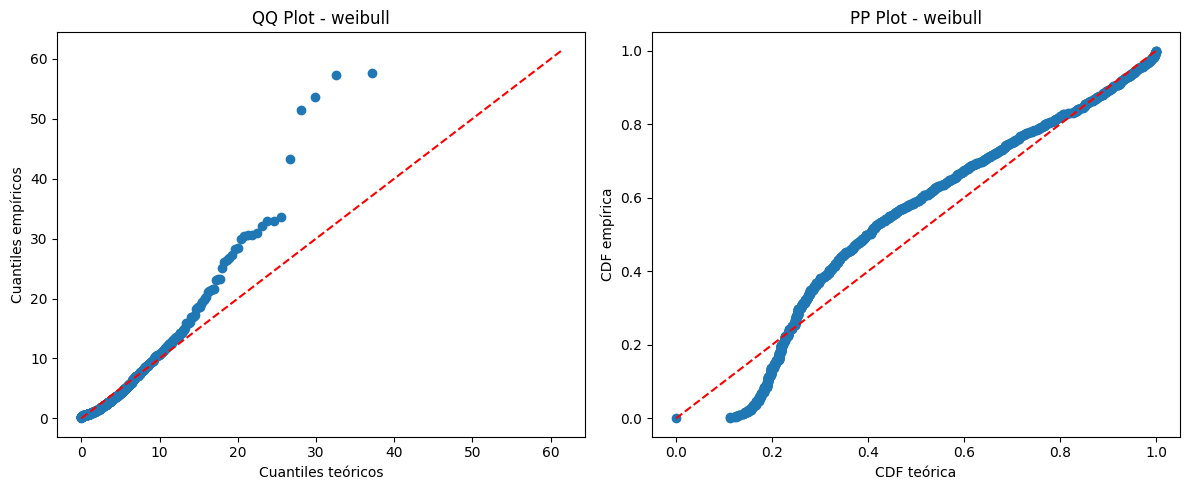

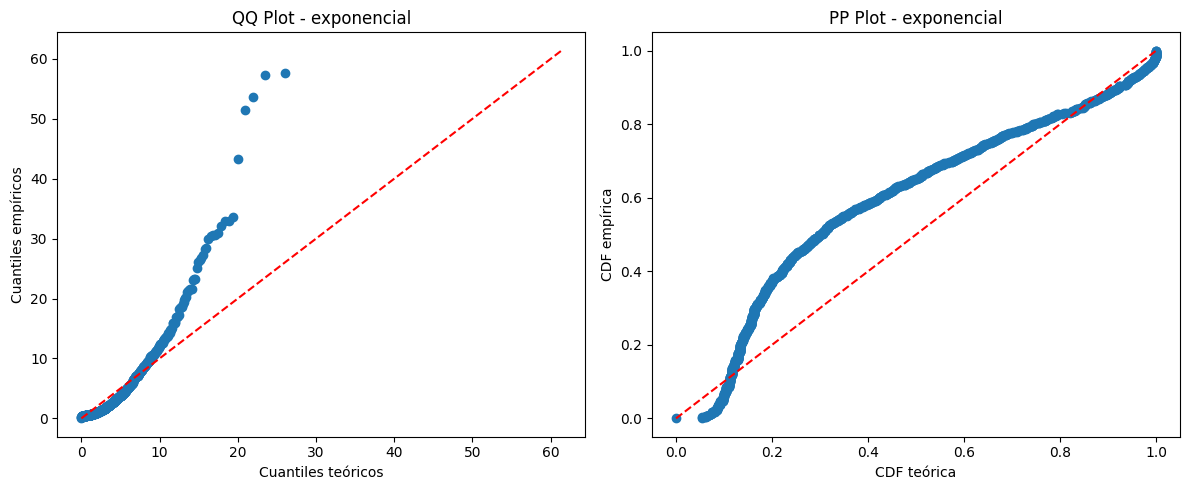

In [31]:
# Ajustar distribuciones
resultados = ajustar_distribuciones(personas_llegada)

print("\nResultados:")
for r in resultados:
    nombre = r['nombre']
    p = r['params']
    rmse = r['rmse']
    ks_p = r['ks_pvalue']
    chi2_p = r['chi2_pvalue']

    # Construcción del string de distribución en formato SIMIO+
    if nombre == 'normal':
        simio_str = f"Normal({p[0]:.4f}, {p[1]:.4f})"
    elif nombre == 'exponencial':
        simio_str = f"Exponential({p[1]:.4f})"
    elif nombre == 'gamma':
        simio_str = f"Gamma({p[0]:.4f}, {p[2]:.4f})"
    elif nombre == 'weibull':
        simio_str = f"Weibull({p[0]:.4f}, {p[2]:.4f})"
    elif nombre == 'lognormal':
        mu = np.log(p[2])
        sigma = p[0]
        simio_str = f"LogNormal({mu:.4f}, {sigma:.4f})"
    elif nombre == 'triangular':
        min_val = p[1]
        max_val = p[1] + p[2]
        mode = min_val + p[2] * p[0]
        simio_str = f"Triangular({min_val:.4f}, {mode:.4f}, {max_val:.4f})"
    else:
        simio_str = f"{nombre.capitalize()}({', '.join(f'{x:.4f}' for x in p)})"

    print(f"{nombre:12} - RMSE: {rmse:.4f} | KS p: {ks_p:.4f} | Chi2 p: {chi2_p:.4f} | SIMIO → {simio_str}")



# Seleccionar y graficar las mejores distribuciones
top_n = 3
mejores = resultados[:top_n]
graficar_resultados(personas_llegada, mejores)

# Graficar QQ y PP plots para las mejores
for res in mejores:
    qq_pp_plots(personas_llegada, res['nombre'], distribuciones[res['nombre']], res['params'])

C:\Users\raalv\AppData\Local\Temp\ipykernel_4384\3044459105.py:21: RuntimeWarning: divide by zero encountered in divide
  chi2 = ((freq_obs - freq_esp)**2 / freq_esp).sum()
C:\Users\raalv\AppData\Local\Temp\ipykernel_4384\3044459105.py:21: RuntimeWarning: invalid value encountered in divide
  chi2 = ((freq_obs - freq_esp)**2 / freq_esp).sum()
C:\Users\raalv\AppData\Local\Temp\ipykernel_4384\3044459105.py:21: RuntimeWarning: divide by zero encountered in divide
  chi2 = ((freq_obs - freq_esp)**2 / freq_esp).sum()
C:\Users\raalv\AppData\Local\Temp\ipykernel_4384\3044459105.py:21: RuntimeWarning: invalid value encountered in divide
  chi2 = ((freq_obs - freq_esp)**2 / freq_esp).sum()
c:\Users\raalv\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_continuous_distns.py:6911: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)



Resultados:
lognormal    - RMSE: 0.0365 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → LogNormal(0.8661, 0.3327)
weibull      - RMSE: 0.0871 | KS p: 0.0000 | Chi2 p: nan | SIMIO → Weibull(1.9104, 2.6402)
normal       - RMSE: 0.0883 | KS p: 0.0000 | Chi2 p: nan | SIMIO → Normal(2.3424, 1.3057)
exponencial  - RMSE: 0.1320 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → Exponential(2.3424)
triangular   - RMSE: 0.1333 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → Triangular(-0.0232, 1.4900, 19.3992)
gamma        - RMSE: 0.1408 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → Gamma(0.4669, 10.0570)


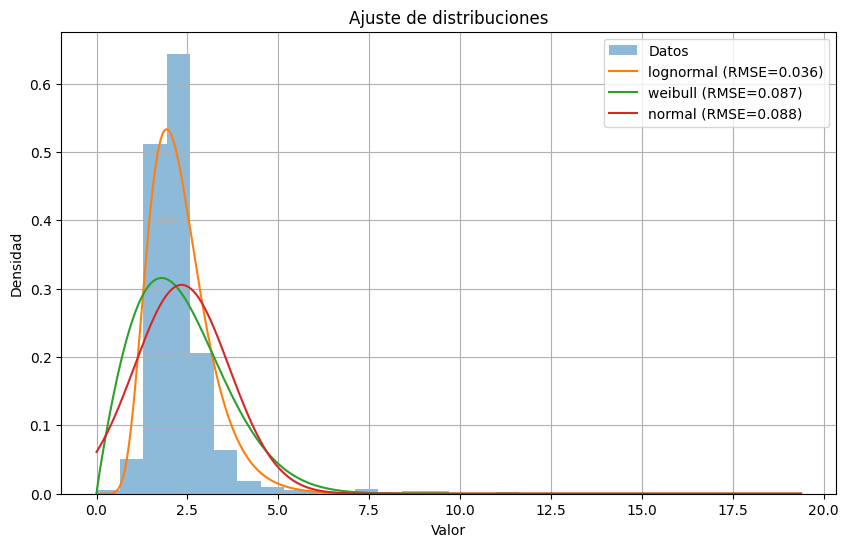

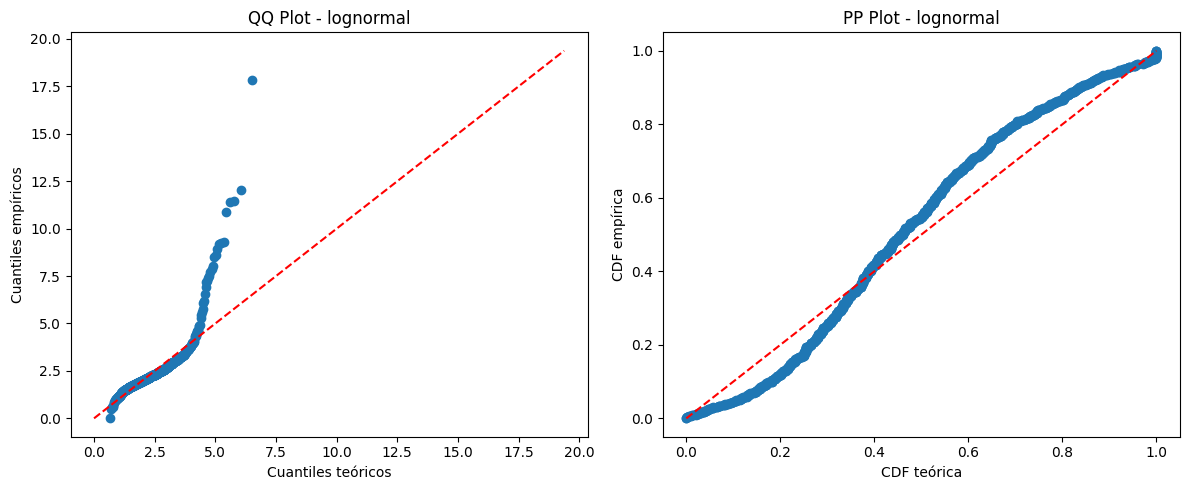

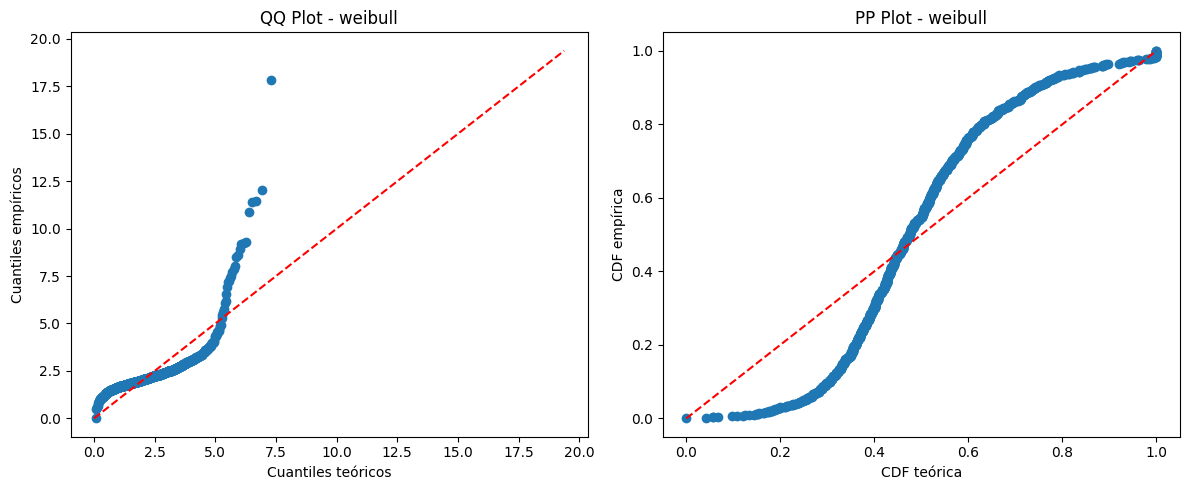

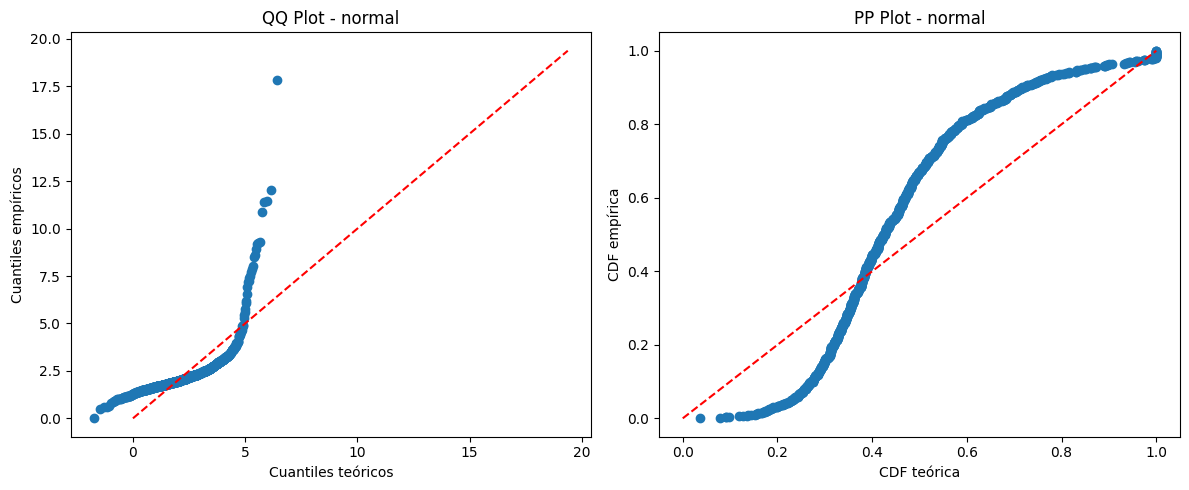

In [34]:
# Ajustar distribuciones
resultados = ajustar_distribuciones(personas_subida)

print("\nResultados:")
for r in resultados:
    nombre = r['nombre']
    p = r['params']
    rmse = r['rmse']
    ks_p = r['ks_pvalue']
    chi2_p = r['chi2_pvalue']

    # Construcción del string de distribución en formato SIMIO+
    if nombre == 'normal':
        simio_str = f"Normal({p[0]:.4f}, {p[1]:.4f})"
    elif nombre == 'exponencial':
        simio_str = f"Exponential({p[1]:.4f})"
    elif nombre == 'gamma':
        simio_str = f"Gamma({p[0]:.4f}, {p[2]:.4f})"
    elif nombre == 'weibull':
        simio_str = f"Weibull({p[0]:.4f}, {p[2]:.4f})"
    elif nombre == 'lognormal':
        mu = np.log(p[2])
        sigma = p[0]
        simio_str = f"LogNormal({mu:.4f}, {sigma:.4f})"
    elif nombre == 'triangular':
        min_val = p[1]
        max_val = p[1] + p[2]
        mode = min_val + p[2] * p[0]
        simio_str = f"Triangular({min_val:.4f}, {mode:.4f}, {max_val:.4f})"
    else:
        simio_str = f"{nombre.capitalize()}({', '.join(f'{x:.4f}' for x in p)})"

    print(f"{nombre:12} - RMSE: {rmse:.4f} | KS p: {ks_p:.4f} | Chi2 p: {chi2_p:.4f} | SIMIO → {simio_str}")



# Seleccionar y graficar las mejores distribuciones
top_n = 3
mejores = resultados[:top_n]
graficar_resultados(personas_subida, mejores)

# Graficar QQ y PP plots para las mejores
for res in mejores:
    qq_pp_plots(personas_subida, res['nombre'], distribuciones[res['nombre']], res['params'])

c:\Users\raalv\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_continuous_distns.py:6911: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
c:\Users\raalv\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2055: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)



Resultados:
weibull      - RMSE: 0.0028 | KS p: 0.5998 | Chi2 p: 0.0000 | SIMIO → Weibull(3.7396, 228.7905)
normal       - RMSE: 0.0029 | KS p: 0.7815 | Chi2 p: 0.0082 | SIMIO → Normal(197.5500, 72.9044)
gamma        - RMSE: 0.0029 | KS p: 0.7656 | Chi2 p: 0.0043 | SIMIO → Gamma(302.1426, 4.3083)
triangular   - RMSE: 0.0034 | KS p: 0.0448 | Chi2 p: 0.4250 | SIMIO → Triangular(-39.0274, 334.0000, 334.0003)
exponencial  - RMSE: 0.0041 | KS p: 0.0021 | Chi2 p: 0.0001 | SIMIO → Exponential(197.5500)
lognormal    - RMSE: 0.0046 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → LogNormal(-32.1911, 163.4014)


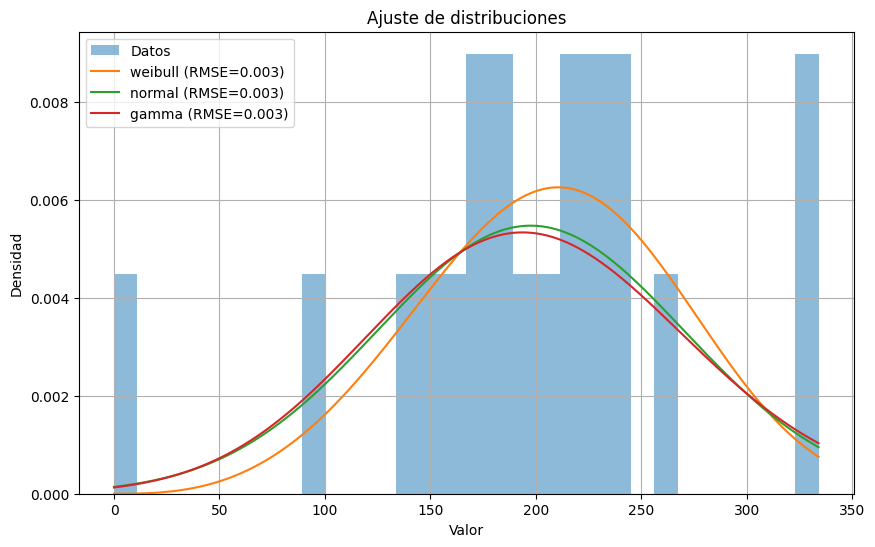

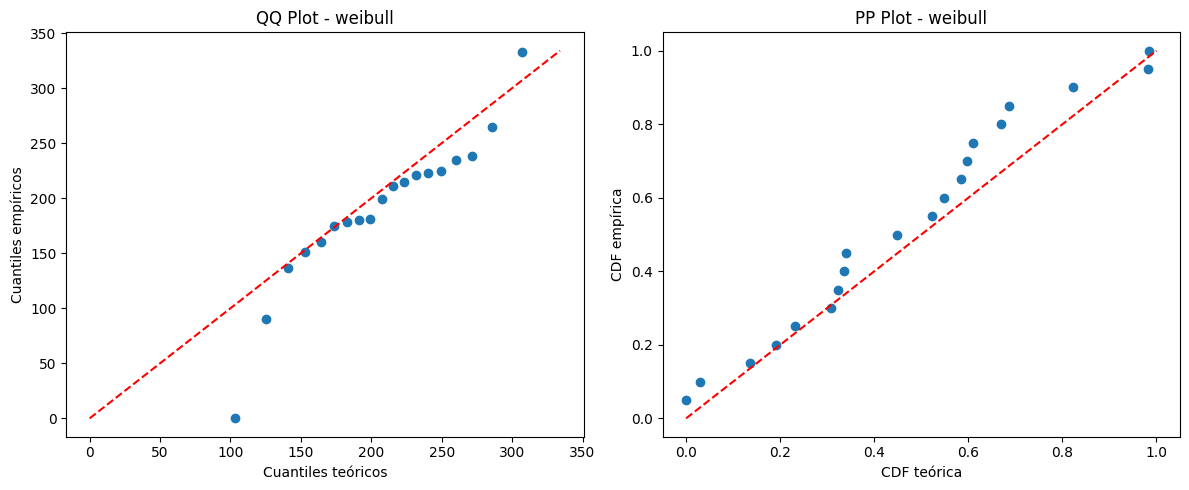

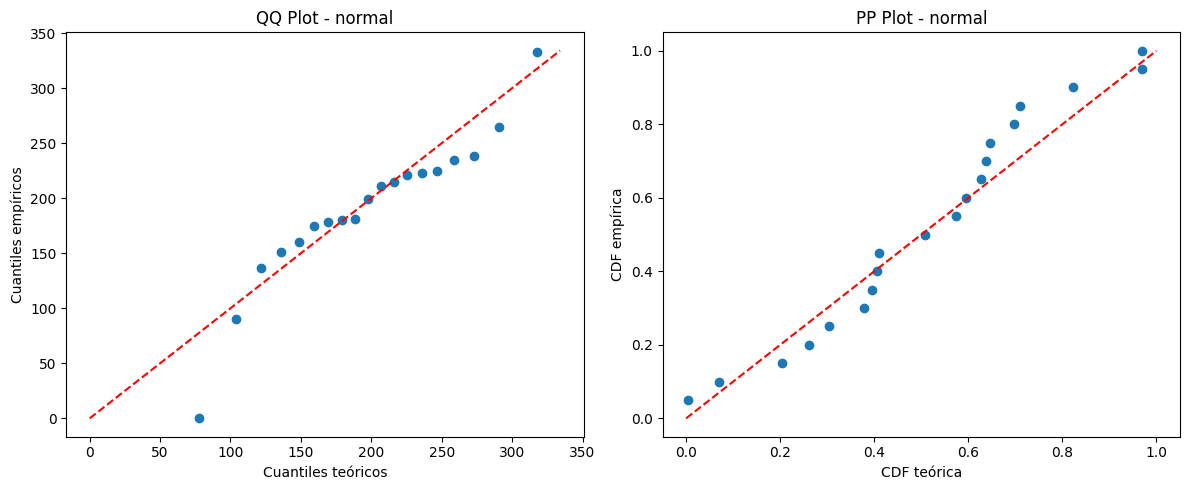

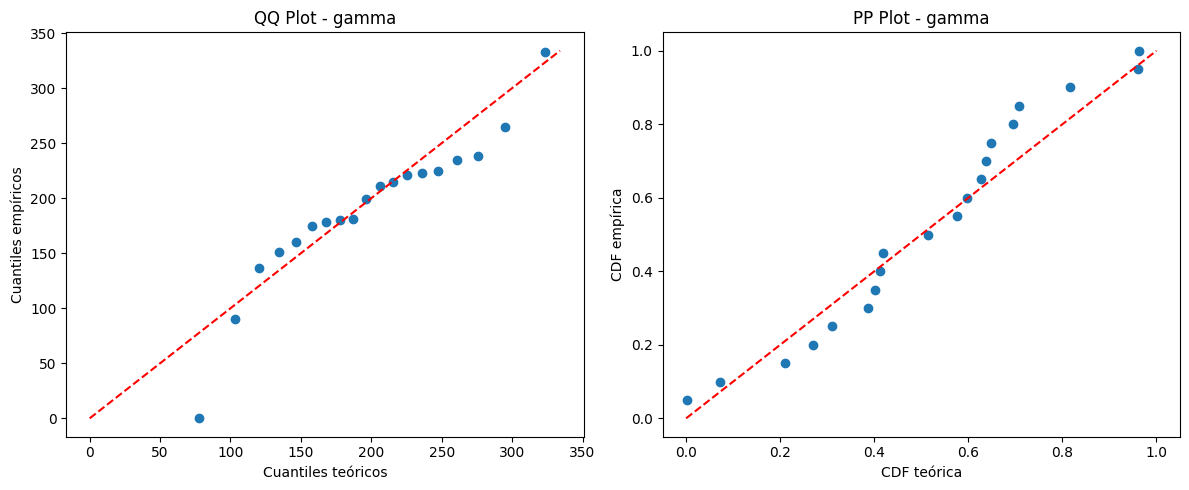

In [35]:
# Ajustar distribuciones
resultados = ajustar_distribuciones(buses_llegada)

print("\nResultados:")
for r in resultados:
    nombre = r['nombre']
    p = r['params']
    rmse = r['rmse']
    ks_p = r['ks_pvalue']
    chi2_p = r['chi2_pvalue']

    # Construcción del string de distribución en formato SIMIO+
    if nombre == 'normal':
        simio_str = f"Normal({p[0]:.4f}, {p[1]:.4f})"
    elif nombre == 'exponencial':
        simio_str = f"Exponential({p[1]:.4f})"
    elif nombre == 'gamma':
        simio_str = f"Gamma({p[0]:.4f}, {p[2]:.4f})"
    elif nombre == 'weibull':
        simio_str = f"Weibull({p[0]:.4f}, {p[2]:.4f})"
    elif nombre == 'lognormal':
        mu = np.log(p[2])
        sigma = p[0]
        simio_str = f"LogNormal({mu:.4f}, {sigma:.4f})"
    elif nombre == 'triangular':
        min_val = p[1]
        max_val = p[1] + p[2]
        mode = min_val + p[2] * p[0]
        simio_str = f"Triangular({min_val:.4f}, {mode:.4f}, {max_val:.4f})"
    else:
        simio_str = f"{nombre.capitalize()}({', '.join(f'{x:.4f}' for x in p)})"

    print(f"{nombre:12} - RMSE: {rmse:.4f} | KS p: {ks_p:.4f} | Chi2 p: {chi2_p:.4f} | SIMIO → {simio_str}")



# Seleccionar y graficar las mejores distribuciones
top_n = 3
mejores = resultados[:top_n]
graficar_resultados(buses_llegada, mejores)

# Graficar QQ y PP plots para las mejores
for res in mejores:
    qq_pp_plots(buses_llegada, res['nombre'], distribuciones[res['nombre']], res['params'])


Resultados:
normal       - RMSE: 0.0062 | KS p: 0.4049 | Chi2 p: 0.0000 | SIMIO → Normal(141.7500, 40.8471)
gamma        - RMSE: 0.0063 | KS p: 0.3726 | Chi2 p: 0.0000 | SIMIO → Gamma(242.9868, 2.7832)
triangular   - RMSE: 0.0065 | KS p: 0.0562 | Chi2 p: 0.1286 | SIMIO → Triangular(-13.1246, 167.0000, 217.3219)
exponencial  - RMSE: 0.0084 | KS p: 0.0003 | Chi2 p: 0.0000 | SIMIO → Exponential(141.7500)
lognormal    - RMSE: 0.0089 | KS p: 0.0000 | Chi2 p: 0.0000 | SIMIO → LogNormal(-32.4811, 163.3347)
weibull      - RMSE: 0.0103 | KS p: 0.0000 | Chi2 p: nan | SIMIO → Weibull(1.0000, 1.0500)


C:\Users\raalv\AppData\Local\Temp\ipykernel_4384\3044459105.py:21: RuntimeWarning: divide by zero encountered in divide
  chi2 = ((freq_obs - freq_esp)**2 / freq_esp).sum()
C:\Users\raalv\AppData\Local\Temp\ipykernel_4384\3044459105.py:21: RuntimeWarning: invalid value encountered in divide
  chi2 = ((freq_obs - freq_esp)**2 / freq_esp).sum()
c:\Users\raalv\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_continuous_distns.py:6911: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
c:\Users\raalv\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2055: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


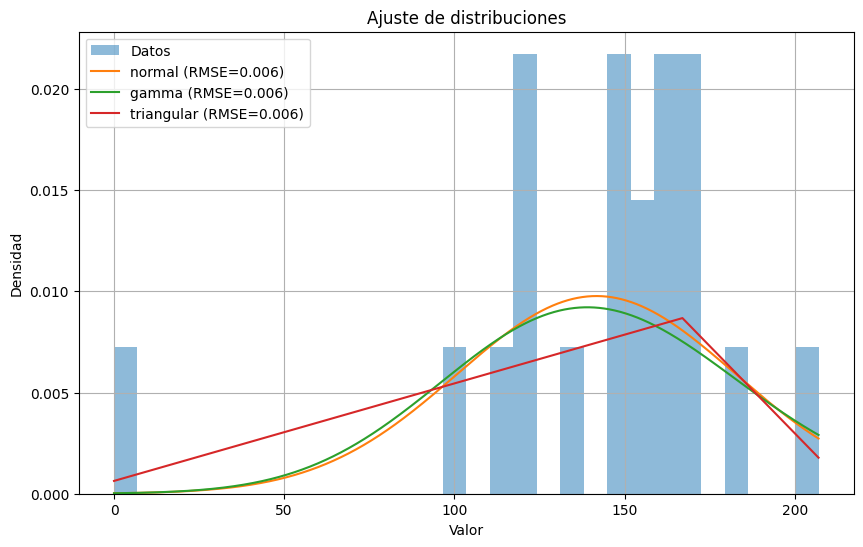

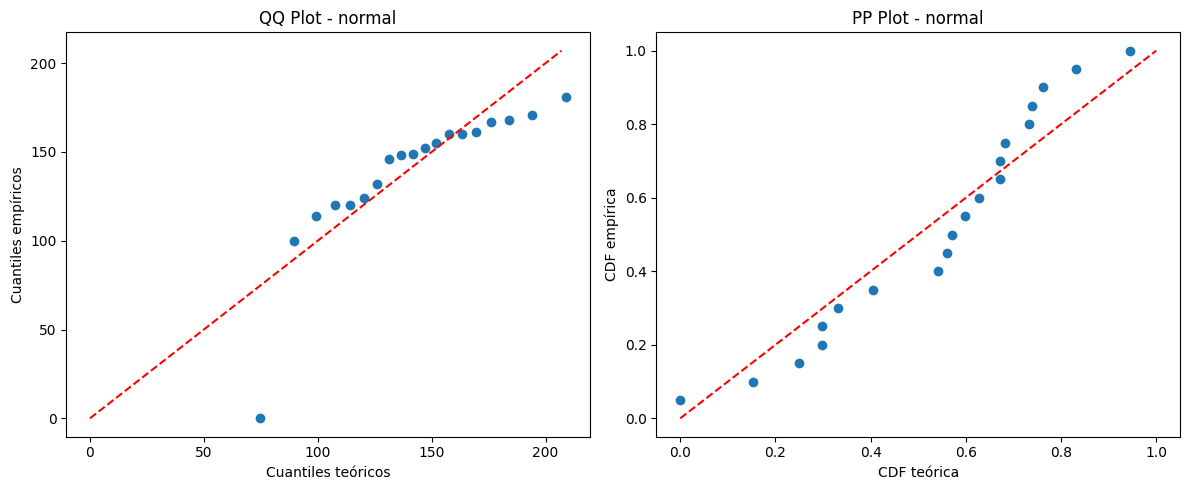

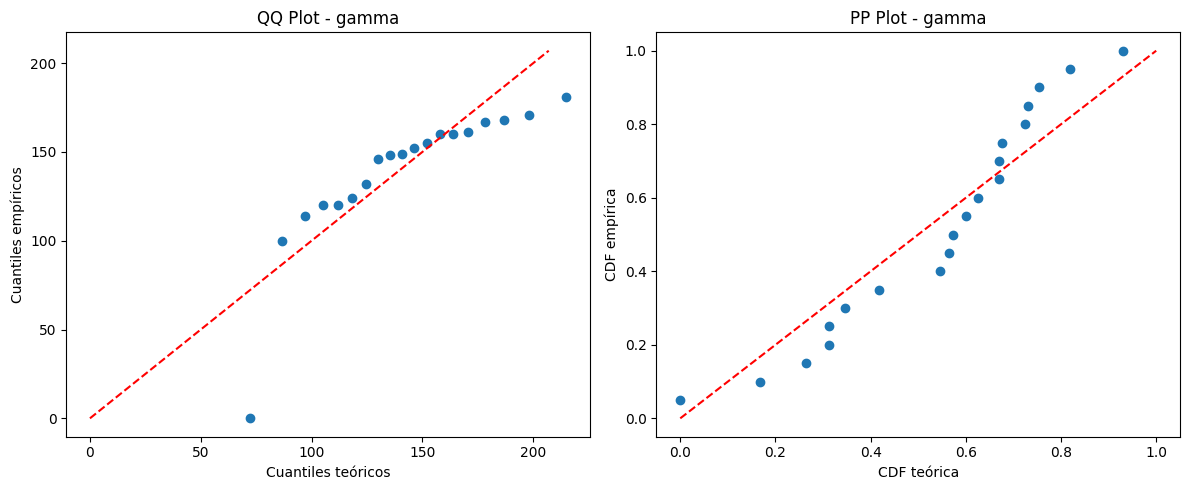

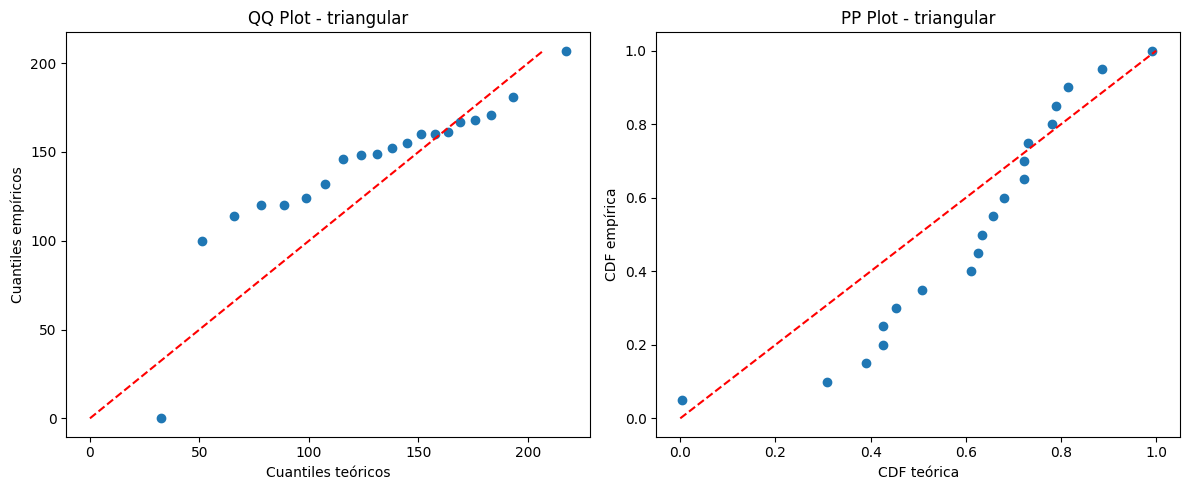

In [36]:
# Ajustar distribuciones
resultados = ajustar_distribuciones(buses_salida)

print("\nResultados:")
for r in resultados:
    nombre = r['nombre']
    p = r['params']
    rmse = r['rmse']
    ks_p = r['ks_pvalue']
    chi2_p = r['chi2_pvalue']

    # Construcción del string de distribución en formato SIMIO+
    if nombre == 'normal':
        simio_str = f"Normal({p[0]:.4f}, {p[1]:.4f})"
    elif nombre == 'exponencial':
        simio_str = f"Exponential({p[1]:.4f})"
    elif nombre == 'gamma':
        simio_str = f"Gamma({p[0]:.4f}, {p[2]:.4f})"
    elif nombre == 'weibull':
        simio_str = f"Weibull({p[0]:.4f}, {p[2]:.4f})"
    elif nombre == 'lognormal':
        mu = np.log(p[2])
        sigma = p[0]
        simio_str = f"LogNormal({mu:.4f}, {sigma:.4f})"
    elif nombre == 'triangular':
        min_val = p[1]
        max_val = p[1] + p[2]
        mode = min_val + p[2] * p[0]
        simio_str = f"Triangular({min_val:.4f}, {mode:.4f}, {max_val:.4f})"
    else:
        simio_str = f"{nombre.capitalize()}({', '.join(f'{x:.4f}' for x in p)})"

    print(f"{nombre:12} - RMSE: {rmse:.4f} | KS p: {ks_p:.4f} | Chi2 p: {chi2_p:.4f} | SIMIO → {simio_str}")



# Seleccionar y graficar las mejores distribuciones
top_n = 3
mejores = resultados[:top_n]
graficar_resultados(buses_salida, mejores)

# Graficar QQ y PP plots para las mejores
for res in mejores:
    qq_pp_plots(buses_salida, res['nombre'], distribuciones[res['nombre']], res['params'])